# Исследование объявлений о продаже квартир

#### Входные данные
Архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет по сервису Яндекс.Недвижимость. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

#### Задача

* Изучить параметры. Убрать редкие и выбивающиеся значения.
* Определить, какие факторы влияют на стоимость квартиры.
* Посчитать среднюю цену квадратного метра в населенных пунктах с наибольшим числом объявлений.
* Выделить сегмент квартир в центре. Проанализировать эту территорию и определить, отличаются ли параметры от всей базы.

Результаты исследования позволят построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

## Изучение данных из файла

Сформируем первое представление о данных:

In [1]:
# Импортируем нужные библиотеки
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Отключим варнинги
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Прочитаем файл с датасетом, сохраним в переменной df и выведем первые 5 строк
df = pd.read_csv('real_estate_data.csv', sep='\t')

In [3]:
# Выведем общую информацию о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

### Вывод

В таблице 22 столбца. Согласно документации к данным:
* airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
* balcony — число балконов
* ceiling_height — высота потолков (м)
* cityCenters_nearest — расстояние до центра города (м)
* days_exposition — сколько дней было размещено объявление (от публикации до снятия)
* first_day_exposition — дата публикации
* floor — этаж
* floors_total — всего этажей в доме
* is_apartment — апартаменты (булев тип)
* kitchen_area — площадь кухни в квадратных метрах (м²)
* last_price — цена на момент снятия с публикации
* living_area — жилая площадь в квадратных метрах (м²)
* locality_name — название населённого пункта
* open_plan — свободная планировка (булев тип)
* parks_around3000 — число парков в радиусе 3 км
* parks_nearest — расстояние до ближайшего парка (м)
* ponds_around3000 — число водоёмов в радиусе 3 км
* ponds_nearest — расстояние до ближайшего водоёма (м)
* rooms — число комнат
* studio — квартира-студия (булев тип)
* total_area — площадь квартиры в квадратных метрах (м²)
* total_images — число фотографий квартиры в объявлении

Количество значений в столбцах различается. Значит в данных есть пропущенные значения.

## Предобработка данных

### Работа со столбцами

In [4]:
# Приведем столбец cityCenters_nearest к змеиному регистру
df = df.rename(columns={'cityCenters_nearest': 'city_centers_nearest'})

In [5]:
# Удалим столбец total_images, так как он не понадобится в исследовании
df = df.drop('total_images', axis=1)

### Устранение дубликатов

Проверим датасет на дубликаты:

In [6]:
# Колчество строк-явных дубликатов
df.duplicated().sum()

0

Явных дубликатов не обнаружено. Проверим неявные дубликаты в столбце `locality_name`:

In [7]:
# Список уникальных значений в столбце
df['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [8]:
# Количество уникальных значений в столбце
len(df['locality_name'].unique())

365

Заметим, что в названиях повторяются разные вариации одного и того же слова. Например:
* "посёлок" и "поселок";
* "городской поселок", "городской посёлок" и "поселок городского типа".

Некоторые названия содержат тип населенного пункта, а некоторые — нет. Например:
* "Мурино" и "поселок Мурино".

Чтобы привести названия к единому образцу, уберем для каждого из них тип населенного пункта из названия:

In [9]:
# Приведем названия к нижнему регистру и заменим е на ё в слове «поселок»
df['locality_name'] = df['locality_name'].str.lower().str.replace('посёлок', 'поселок')

# Создадим список с типами населенных пунктов
location_types = ['поселок городского типа',
                  'городской поселок',
                  'коттеджный поселок',
                  'поселок при железнодорожной станции',
                  'поселок',
                  'село',
                  'деревня',
                  'садовое товарищество',
                  'садоводческое некоммерческое товарищество']

# В цикле заменим все вхождения типа населенного пункта из location_types на пустую строку
for location_type in location_types:
    df['locality_name'] = df['locality_name'].str.replace(location_type + ' ', '')

# Выведем список уникальных значений в столбце
df['locality_name'].unique()

array(['санкт-петербург', 'шушары', 'янино-1', 'парголово', 'мурино',
       'ломоносов', 'сертолово', 'петергоф', 'пушкин', 'кудрово',
       'коммунар', 'колпино', 'красный бор', 'гатчина', 'фёдоровское',
       'выборг', 'кронштадт', 'кировск', 'новое девяткино',
       'металлострой', 'лебяжье', 'сиверский', 'молодцово',
       'кузьмоловский', 'новая ропша', 'павловск', 'пикколово',
       'всеволожск', 'волхов', 'кингисепп', 'приозерск', 'сестрорецк',
       'куттузи', 'аннино', 'ефимовский', 'плодовое', 'заклинье',
       'торковичи', 'первомайское', 'красное село', 'понтонный',
       'сясьстрой', 'старая', 'лесколово', 'новый свет', 'сланцы',
       'путилово', 'ивангород', 'шлиссельбург', 'никольское',
       'зеленогорск', 'сосновый бор', 'оржицы', 'кальтино', 'романовка',
       'бугры', 'рощино', 'кириши', 'луга', 'волосово', 'отрадное',
       'павлово', 'оредеж', 'копорье', 'молодёжное', 'тихвин', 'победа',
       'нурма', 'синявино', 'тосно', 'стрельна', 'бокситогорск',

In [10]:
# Количество уникальных значений в столбце
len(df['locality_name'].unique())

309

### Замена пропусков

Посчитаем, какую долю составляют пропущенные значения в таблице:

In [11]:
df.isna().mean()

last_price              0.000000
total_area              0.000000
first_day_exposition    0.000000
rooms                   0.000000
ceiling_height          0.387991
floors_total            0.003629
living_area             0.080299
floor                   0.000000
is_apartment            0.882906
studio                  0.000000
open_plan               0.000000
kitchen_area            0.096122
balcony                 0.486054
locality_name           0.002068
airports_nearest        0.233850
city_centers_nearest    0.232879
parks_around3000        0.232837
parks_nearest           0.659100
ponds_around3000        0.232837
ponds_nearest           0.615596
days_exposition         0.134225
dtype: float64

В столбце `balcony` (число балконов) пропущенные значения могут означать отсутствие балконов. Заменим пропуски на 0:

In [12]:
df['balcony'] = df['balcony'].fillna(0)

Аналогично со столбцом `is_apartment`. Так как апартаменты — редкий вид жилья, пропуск в этом столбце может означать, что квартира не относится к этому типу. Заменим пропуски на "False":

In [13]:
df['is_apartment'] = df['is_apartment'].fillna("False")

Пропуски в `ceiling_height` заполним медианным значением:

In [14]:
df['ceiling_height'] = df['ceiling_height'].fillna(df['ceiling_height'].median())

Для заполнения пропусков в `living_area` и `kitchen_area`:

In [15]:
# Сгруппируем датасет по количеству комнат
grouped_by_rooms = df.groupby('rooms')

# Создадим два новых столбца: с отношением жилой площади к общей, а также с отношением площади кухни к общей
df['living_to_total_ratio'] = df['living_area'] / df['total_area']
df['kitchen_to_total_ratio'] = df['kitchen_area'] / df['total_area']

# Заполним пропуски в `living_to_total_ratio` и `kitchen_to_total_ratio` медианным отношением в зависимости от числа комнат
df['living_to_total_ratio'] = df['living_to_total_ratio'].fillna(grouped_by_rooms['living_to_total_ratio'].transform('median'))
df['kitchen_to_total_ratio'] = df['kitchen_to_total_ratio'].fillna(grouped_by_rooms['kitchen_to_total_ratio'].transform('median'))

# Заполним пропуски в `living_area` и `kitchen_area`, пользуясь известным отношением
df['living_area'] = df['living_area'].fillna(df['total_area'] * df['living_to_total_ratio'])
df['kitchen_area'] = df['kitchen_area'].fillna(df['total_area'] * df['kitchen_to_total_ratio'])

Проверим, все ли пропуски удалось заполнить:

In [16]:
df.isna().sum()

last_price                    0
total_area                    0
first_day_exposition          0
rooms                         0
ceiling_height                0
floors_total                 86
living_area                   0
floor                         0
is_apartment                  0
studio                        0
open_plan                     0
kitchen_area                197
balcony                       0
locality_name                49
airports_nearest           5542
city_centers_nearest       5519
parks_around3000           5518
parks_nearest             15620
ponds_around3000           5518
ponds_nearest             14589
days_exposition            3181
living_to_total_ratio         0
kitchen_to_total_ratio      197
dtype: int64

В столбце с площадью кухни остались пропущенные значения. Заметим, что число пропусков соответствует числу квартир, у которых rooms = 0. Проверим, действительно ли это так:

In [17]:
# Число квартир с rooms = 0
df.query('rooms == 0').shape[0]

197

Вероятно, значение комнат 0 соответствует квартирам со свободной планировкой и квартирам-студиям. Проверим:

In [18]:
# Число квартир с rooms = 0, тип которых соответствует студии или свободной планировке
df.query('rooms == 0 & (studio == True | open_plan == True)').shape[0]

197

In [19]:
# Проверим, что множества квартир со свободной планировкой и студий не пересекаются
df.query('studio == True & open_plan == True').shape[0]

0

Действительно, отсюда и пропуск в площади кухни. Ведь в квартирах этих типов кухонная и жилая зона совмещены. Заполним пропуск значением 0 (так как нет комнаты, выделенной под кухню):

In [20]:
df['kitchen_area'] = df['kitchen_area'].fillna(0)
df['kitchen_to_total_ratio'] = df['kitchen_to_total_ratio'].fillna(0)

Большое количество пропусков наблюдается в столбцах `airports_nearest`, `city_centers_nearest`, `parks_around3000`, `parks_nearest`, `ponds_around3000`, `ponds_nearest`. Рассмотрим варианты их заполнения:
1. Сгруппировать датасет по населенному пункту, найти медианы и заполнить пропуски медианным значением
  
  У данного способа два недостатка:
  * есть населенные пункты, для которых все записи о расстояниях пропущены, и их доля велика
  * если таким образом заполнить пропуски для Санкт-Петербурга, это исказит результаты для корреляции между ценой и удаленностью от центра по этому городу


2. Заполнить медианным значением по столбцу
  
  Пропущено около 20% данных, в parks_nearest и ponds_nearest — целых 60%. Данный способ также исказит результаты исследования


Так как параметр `city_centers_nearest` может быть использован для исследования по Санкт-Петербургу, проверим, что доля пропущенных значений по этому городу не превышает допустимую и оставим его. Остальные столбцы не представляют ценности для исследования из-за большого числа пропусков, поэтому их можно удалить. Заметим также, что все эти столбцы получены автоматически на основе картографических данных, то есть причина пропусков, вероятно, в неправильной выгрузке (в реальной задаче я бы уточнила этот вопрос у коллеги, чтобы не терять такое количество данных).

In [21]:
# Доля пропущенных значений в city_centers_nearest для г. Санкт-Петербурга
df.query('locality_name == "санкт-петербург"').isna()['city_centers_nearest'].mean()

0.003880160295146619

Пропущенных значений меньше 1%, оставим этот столбец для дальнейшего исследования.

In [22]:
# Удаление столбцов
df = df.drop(['airports_nearest',
              'parks_around3000',
              'parks_nearest',
              'ponds_around3000',
              'ponds_nearest'],
             axis=1)
df.columns

Index(['last_price', 'total_area', 'first_day_exposition', 'rooms',
       'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'city_centers_nearest', 'days_exposition',
       'living_to_total_ratio', 'kitchen_to_total_ratio'],
      dtype='object')

Пропуски в `floors_total` можно оставить нетронутыми (заменим на 0 для удобства форматирования). Этот столбец понадобится при категоризации этажа («первый», «последний», «другой»):
- Если значение `floor` равно 1, этажу будет назначена категория «первый» вне зависимости от значения в `floors_total`. 
- Если же значение `floor` не равно 1, а в `floors_total` пропуск, назначим этажу категорию «другой». Доля таких данных мала (меньше 1%), поэтому это не повлияет на результат исследования.

In [23]:
# Доля записей, у которых floor отличен от 1, а значение floors_total не указано
df.query('floor != 1 & floors_total.isna()', engine='python').shape[0] / df.shape[0]

0.0035022574792185324

In [24]:
# Замена пропусков в floors_total на 0
df['floors_total'] = df['floors_total'].fillna(0)

Также оставим пропуски в `days_exposition`.

Пропуски в `locality_name` удалим (их менее 0.3%), так как эти объявления могут не относиться к Ленинградской области.

In [25]:
# Удаление строк с пропусками в locality_name
df = df.dropna(axis=0, subset=['locality_name'])

Результат заполнения части пропусков:

In [26]:
# Доля пропущенных значений в таблице
df.isna().mean()

last_price                0.000000
total_area                0.000000
first_day_exposition      0.000000
rooms                     0.000000
ceiling_height            0.000000
floors_total              0.000000
living_area               0.000000
floor                     0.000000
is_apartment              0.000000
studio                    0.000000
open_plan                 0.000000
kitchen_area              0.000000
balcony                   0.000000
locality_name             0.000000
city_centers_nearest      0.233023
days_exposition           0.134461
living_to_total_ratio     0.000000
kitchen_to_total_ratio    0.000000
dtype: float64

### Изменение типов данных

In [27]:
# Проверим тип данных в столбцах
df.dtypes

last_price                float64
total_area                float64
first_day_exposition       object
rooms                       int64
ceiling_height            float64
floors_total              float64
living_area               float64
floor                       int64
is_apartment               object
studio                       bool
open_plan                    bool
kitchen_area              float64
balcony                   float64
locality_name              object
city_centers_nearest      float64
days_exposition           float64
living_to_total_ratio     float64
kitchen_to_total_ratio    float64
dtype: object

In [28]:
# Выведем первые 10 строк таблицы
df.head(10)

,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,city_centers_nearest,days_exposition,living_to_total_ratio,kitchen_to_total_ratio
0,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.000000,8,False,False,False,25.000000,0.0,санкт-петербург,16028.0,NaN,0.472222,0.231481
1,3350000.0,40.40,2018-12-04T00:00:00,1,2.65,11.0,18.600000,1,False,False,False,11.000000,2.0,шушары,18603.0,81.0,0.460396,0.272277
2,5196000.0,56.00,2015-08-20T00:00:00,2,2.65,5.0,34.300000,4,False,False,False,8.300000,0.0,санкт-петербург,13933.0,558.0,0.612500,0.148214
3,64900000.0,159.00,2015-07-24T00:00:00,3,2.65,14.0,100.435000,9,False,False,False,20.442857,0.0,санкт-петербург,6800.0,424.0,0.631667,0.128571
4,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.000000,13,False,False,False,41.000000,0.0,санкт-петербург,8098.0,121.0,0.320000,0.410000
5,2890000.0,30.40,2018-09-10T00:00:00,1,2.65,12.0,14.400000,5,False,False,False,9.100000,0.0,янино-1,NaN,55.0,0.473684,0.299342
6,3700000.0,37.30,2017-11-02T00:00:00,1,2.65,26.0,10.600000,6,False,False,False,14.400000,1.0,парголово,19143.0,155.0,0.284182,0.386059
7,7915000.0,71.60,2019-04-18T00:00:00,2,2.65,24.0,41.886654,22,False,False,False,18.900000,2.0,санкт-петербург,11634.0,NaN,0.585009,0.263966
8,2900000.0,33.16,2018-05-23T00:00:00,1,2.65,27.0,15.430000,26,False,False,False,8.810000,0.0,мурино,NaN,189.0,0.465320,0.265682
9,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.600000,7,False,False,False,6.500000,2.0,санкт-петербург,15008.0,289.0,0.714754,0.106557


Чтобы в дальнейшем было проще получать значения дня недели, месяца и года размещения объявления, приведем столбец `first_day_exposition` к типу datetime:


In [29]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

Столбцы `last_price`, `floors_total`, `balcony` содержат целочисленные данные. Чтобы не занимать лишнее место в памяти, приведем их к типу int:

In [30]:
for column in ['last_price',
               'floors_total',
               'balcony']:
    df[column] = df[column].astype('int')

Столбец `is_apartment` показывает, является ли квартира апартаментами, и предполагает булев тип. Заменим строковые значения булевыми:

In [31]:
df['is_apartment'] = df['is_apartment'].replace({'True': True, 'False': False})

Результат изменения типов данных:

In [32]:
df.dtypes

last_price                         int32
total_area                       float64
first_day_exposition      datetime64[ns]
rooms                              int64
ceiling_height                   float64
floors_total                       int32
living_area                      float64
floor                              int64
is_apartment                        bool
studio                              bool
open_plan                           bool
kitchen_area                     float64
balcony                            int32
locality_name                     object
city_centers_nearest             float64
days_exposition                  float64
living_to_total_ratio            float64
kitchen_to_total_ratio           float64
dtype: object

## Расчёты и добавление результатов в таблицу

Так как площадь квартир разная и она коррелирует со стоимостью, при сравнении правильнее использовать не стоимость квартиры, а цену квадратного метра.

In [33]:
# Убедимся, что в данных нет площади равной 0
df.query('total_area == 0').shape[0]

0

In [34]:
# Рассчитаем цену квадратного метра как частное от деления стоимости квартиры на площадь
df['sqmeter_price'] = df['last_price'] / df['total_area']

Для дальнейшего исследования зависимости цены от даты размещения (дня недели, месяца и года) создадим соответствующие столбцы:

In [35]:
# День недели размещения объявления
df['weekday'] = df['first_day_exposition'].dt.weekday
# Месяц
df['month'] = df['first_day_exposition'].dt.month
# Год
df['year'] = df['first_day_exposition'].dt.year

Проведем категоризацию этажа квартиры:

In [36]:
# Функция, которая возвращает категорию этажа:
# если значение этажа равно 1 — первый
# если значение этажа равно общему числу этажей в доме — последний
# иначе — другой

def categorize_floor(row):
    if row['floor'] == 1:
        return "первый"
    if row['floor'] == row['floors_total']:
        return "последний"
    return "другой"

# Создание столбца floor_category вызовом функции к датафрейму
df['floor_category'] = df.apply(categorize_floor, axis=1)

Столбцы с соотношением жилой площади к общей (`living_to_total_ratio`) и площади кухни к общей (`kitchen_to_total_ratio`) были добавлены на этапе предобработки данных.

## Исследовательский анализ данных

### Поиск аномалий

In [37]:
# Выведем основные статистики столбцов
df.describe()

,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,city_centers_nearest,days_exposition,living_to_total_ratio,kitchen_to_total_ratio,sqmeter_price,weekday,month,year
count,2.365000e+04,23650.000000,23650.000000,23650.000000,23650.000000,23650.000000,23650.000000,23650.000000,23650.000000,18139.000000,20470.000000,23650.000000,23650.000000,2.365000e+04,23650.000000,23650.000000,23650.000000
mean,6.541127e+06,60.329069,2.070106,2.724311,10.637505,34.681658,5.893277,10.399161,0.591712,14197.860742,180.753200,0.564899,0.185607,9.943225e+04,2.568710,6.401564,2017.370021
std,1.089640e+07,35.661808,1.078620,0.989255,6.613891,22.843412,4.883317,5.854386,0.959662,8606.830295,219.777916,0.102763,0.073189,5.033794e+04,1.788808,3.491418,1.037806
min,1.219000e+04,12.000000,0.000000,1.000000,0.000000,2.000000,1.000000,0.000000,0.000000,181.000000,1.000000,0.021583,0.000000,1.118349e+02,0.000000,1.000000,2014.000000
25%,3.400000e+06,40.000000,1.000000,2.600000,5.000000,18.700000,2.000000,7.000000,0.000000,9241.000000,45.000000,0.491339,0.132208,7.661497e+04,1.000000,3.000000,2017.000000
50%,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.000000,0.000000,13105.000000,95.000000,0.571429,0.169811,9.500000e+04,3.000000,6.000000,2017.000000
75%,6.799000e+06,69.700000,3.000000,2.700000,16.000000,42.318750,8.000000,11.780000,1.000000,16293.000000,231.000000,0.633484,0.235492,1.142742e+05,4.000000,10.000000,2018.000000
max,7.630000e+08,900.000000,19.000000,100.000000,60.000000,430.133948,33.000000,122.457061,5.000000,65968.000000,1580.000000,1.000000,0.787879,1.907500e+06,6.000000,12.000000,2019.000000


Изучим следующие параметры: площадь, цена, число комнат, высота потолков.

<AxesSubplot:title={'center':'ceiling_height'}, ylabel='Frequency'>

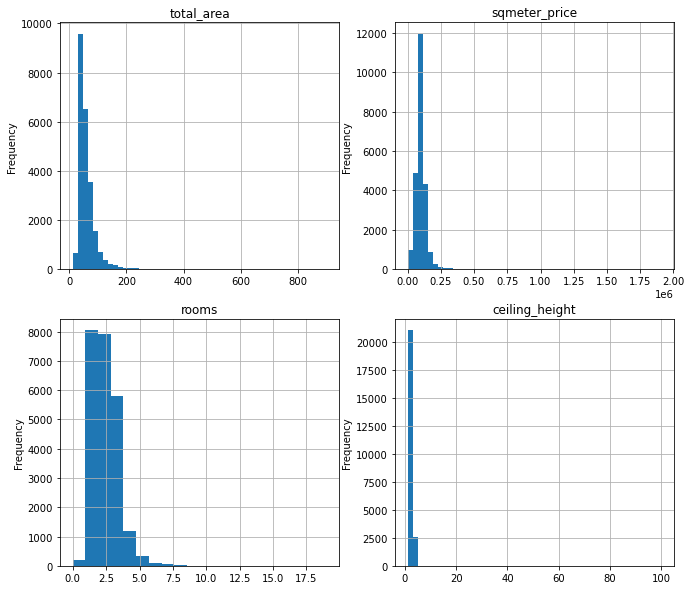

In [38]:
# Создание области figure и массива областей axes
fig, axes = plt.subplots(2, 2)

# Отрисовка гистограмм для каждого столбца
# (здесь реализовано не в цикле, так как количество bins разное)
df['total_area'].plot(kind='hist', bins=50, figsize=(11, 10), ax=axes[0,0], grid=True, title='total_area')
df['sqmeter_price'].plot(kind='hist', bins=50, figsize=(11, 10), ax=axes[0,1], grid=True, title='sqmeter_price')
df['rooms'].plot(kind='hist', bins=20, figsize=(11, 10), ax=axes[1,0], grid=True, title='rooms')
df['ceiling_height'].plot(kind='hist', bins=50, figsize=(11, 10), ax=axes[1,1], grid=True, title='ceiling_height')

Рассмотрим те же гистограммы, но на выбранных промежутках, исключив выбросы сверху:

<AxesSubplot:title={'center':'ceiling_height'}, ylabel='Frequency'>

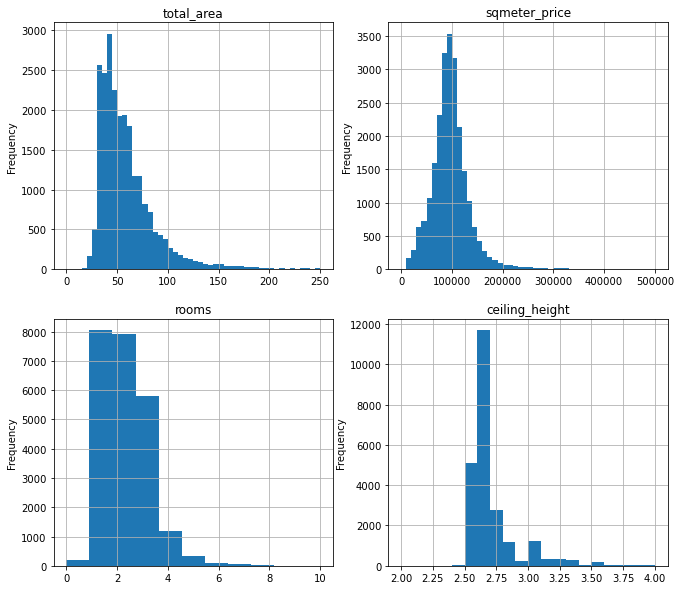

In [39]:
fig, axes = plt.subplots(2, 2)

df['total_area'].plot(kind='hist', bins=50, figsize=(11, 10), ax=axes[0,0], grid=True, title='total_area', range=(0, 250))
df['sqmeter_price'].plot(kind='hist', bins=50, figsize=(11, 10), ax=axes[0,1], grid=True, title='sqmeter_price', range=(0, 500000))
df['rooms'].plot(kind='hist', bins=11, figsize=(11, 10), ax=axes[1,0], grid=True, title='rooms', range=(0,10))
df['ceiling_height'].plot(kind='hist', bins=20, figsize=(11, 10), ax=axes[1,1], grid=True, title='ceiling_height', range=(2, 4))

Внимательнее изучим столбцы `sqmeter_price` и `ceiling_height`:

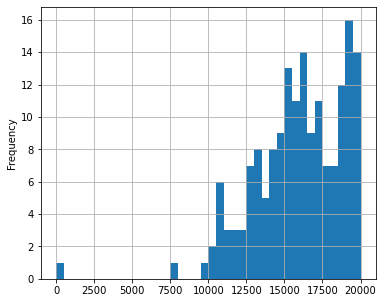

<AxesSubplot:ylabel='Frequency'>

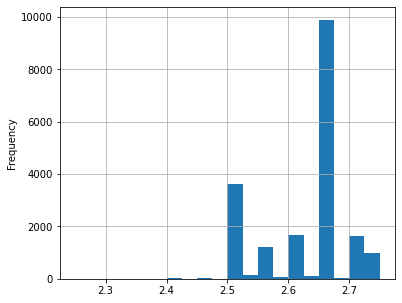

In [40]:
# Построение гистограмм для sqmeter_price и ceiling_height на промежутке снизу (около минимума)
df['sqmeter_price'].plot(kind='hist', bins=40, figsize=(6, 5), grid=True, range=(0, 20000))
plt.show()
df['ceiling_height'].plot(kind='hist', bins=20, figsize=(6, 5), grid=True, range=(2.25, 2.75))

**Вывод.** В данных присутствуют выбросы, о чем свидетельствует таблица (минимум значительно отличается от первого квартиля, а максимум — от третьего) и гистограммы распределения (значительную часть занимают близкие к нулю значения). У столбцов `sqmeter_price` и `ceiling_height` наблюдаются одиночные аномалии близкие к минимуму, которые, вероятно, связаны с ошибками в данных. Характерные значения для каждого из параметров:

* площадь: [12, 200)
* цена: (10000, 250000)
* число комнат: [0, 8]
* высота потолков: [2.5, 4]

После установки верхней и нижней границ рассматриваемых значений распределения стали более близки к нормальным. Аномалии не обязательно свидетельсвуют об ошибках в данных (кроме высоты потолка 100м и пр.). Квартиры с большой площадью и 19 комнатами действительно могли быть в продаже, но такие случаи редки и выборка нерепрезентативна, поэтому для исследования необходимо избавиться от выбросов.

Отфильтруем редкие и выбивающиеся значения для каждого из рассмотренных столбцов и сохраним полученный датафрейм в переменной `good_df`:

In [41]:
good_df = df.query(
    'total_area < 200 & 10000 < sqmeter_price < 250000 & 0 <= rooms <= 8 & 2.5 <= ceiling_height <= 4'
)

Изучим время продажи квартиры `days_exposition`:

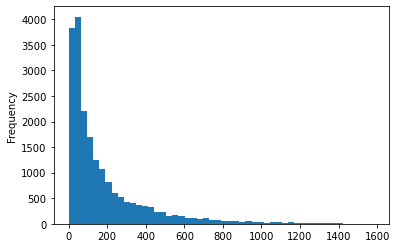

<AxesSubplot:>

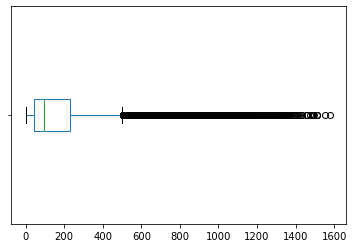

In [42]:
# Отрисовка гистограммы и ящика с усами по столбцу days_exposition
good_df['days_exposition'].plot(kind='hist', bins=50)
plt.show()
good_df['days_exposition'].plot(kind='box', vert=False, label='')

In [43]:
# Основные статистики days_exposition
good_df['days_exposition'].describe()

count    20012.000000
mean       178.811763
std        217.634769
min          1.000000
25%         45.000000
50%         94.000000
75%        228.000000
max       1580.000000
Name: days_exposition, dtype: float64

Большая часть значений лежит в диапазоне от 45 до 228 дней, что выглядит правдоподобно. Продажа, занимающая более 500 дней, выходит за 1.5 межквартильного размаха, поэтому является необычно долгим показателем. Хвост с такими значениями достаточно длинный, среднее в 2 раза больше медианы.

Чтобы выяснить природу высоких значений, отсортируем датафрейм по убыванию времени продажи и выведем первые 10 строк:

In [44]:
good_df.sort_values(by='days_exposition', ascending=False).head(10)

,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,...,locality_name,city_centers_nearest,days_exposition,living_to_total_ratio,kitchen_to_total_ratio,sqmeter_price,weekday,month,year,floor_category
18843,3500000,48.20,2014-12-15,2,2.50,5,27.400000,2,False,False,...,новое девяткино,NaN,1580.0,0.568465,0.159751,72614.107884,0,12,2014,другой
9553,10600000,80.00,2014-12-09,3,2.85,17,44.000000,9,False,False,...,санкт-петербург,17110.0,1553.0,0.550000,0.187500,132500.000000,1,12,2014,другой
1885,13300000,79.60,2014-12-09,2,3.00,8,42.700000,7,False,False,...,санкт-петербург,11096.0,1513.0,0.536432,0.226131,167085.427136,1,12,2014,другой
20969,13300000,133.00,2015-02-11,4,3.00,5,58.000000,2,False,False,...,санкт-петербург,5032.0,1512.0,0.436090,0.338346,100000.000000,2,2,2015,другой
6691,4400000,42.98,2014-12-12,1,2.65,5,18.720000,1,False,False,...,пушкин,30358.0,1512.0,0.435551,0.263146,102373.196836,4,12,2014,первый
14093,9500000,100.00,2015-02-19,4,3.00,5,76.000000,5,False,False,...,санкт-петербург,4798.0,1497.0,0.760000,0.100000,95000.000000,3,2,2015,последний
15313,9278000,139.80,2014-12-28,4,2.80,5,92.231688,4,False,False,...,сестрорецк,35515.0,1489.0,0.659740,0.112245,66366.237482,6,12,2014,другой
19123,5990000,82.00,2015-02-19,3,3.00,4,60.000000,2,False,False,...,павловск,34619.0,1485.0,0.731707,0.097561,73048.780488,3,2,2015,другой
11955,11400000,76.00,2014-12-09,2,2.65,9,36.000000,3,False,False,...,санкт-петербург,11096.0,1484.0,0.473684,0.184211,150000.000000,1,12,2014,другой
4736,6650000,68.30,2015-02-19,4,2.63,5,45.100000,4,False,False,...,санкт-петербург,1724.0,1477.0,0.660322,0.131772,97364.568082,3,2,2015,другой


Заметим, что все объявления с высоким сроком продажи были выложены в 2014 или 2015 году. Изучим детальнее данные по годам:

In [45]:
# Основные статистики по годам
good_df.groupby('year')['days_exposition'].describe()

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2014,109.0,903.605505,297.690711,554.0,606.0,870.0,1133.00,1580.0
2015,1057.0,650.759697,319.000275,182.0,390.0,580.0,888.00,1512.0
2016,2616.0,320.894495,256.404955,3.0,114.0,235.5,476.25,1153.0
2017,7728.0,157.912526,152.215747,3.0,45.0,102.0,225.00,814.0
2018,7440.0,93.991667,84.905115,3.0,34.0,63.0,130.00,465.0
2019,1062.0,31.006591,23.889688,1.0,12.0,23.5,45.00,110.0


<AxesSubplot:title={'center':'days_exposition'}, xlabel='year'>

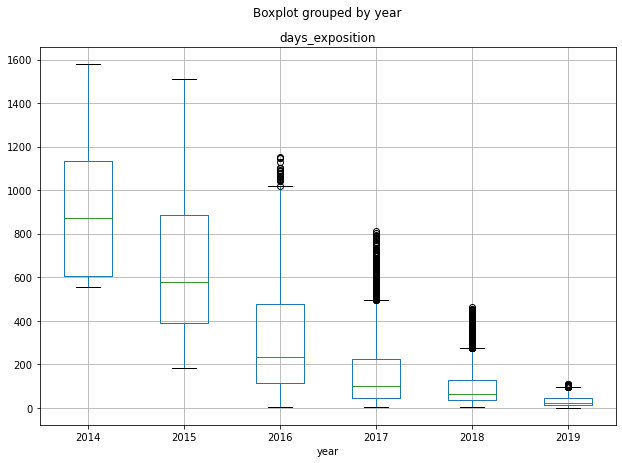

In [46]:
# Ящики с усами для каждого года
good_df.boxplot(column='days_exposition', by='year', figsize=(10, 7))

array([[<AxesSubplot:title={'center':'2014'}>,
        <AxesSubplot:title={'center':'2015'}>],
       [<AxesSubplot:title={'center':'2016'}>,
        <AxesSubplot:title={'center':'2017'}>],
       [<AxesSubplot:title={'center':'2018'}>,
        <AxesSubplot:title={'center':'2019'}>]], dtype=object)

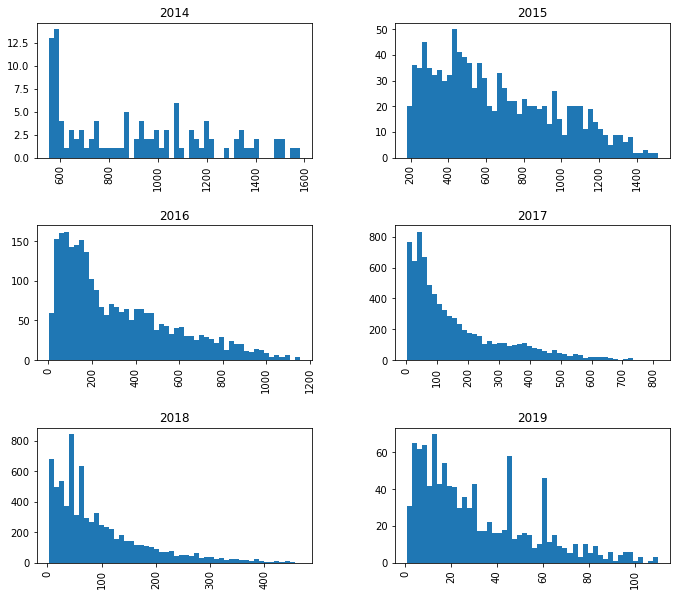

In [47]:
# Гистограммы для каждого года
good_df.hist(column='days_exposition', by='year', figsize=(11, 10), bins=50)

Прослеживается закономерность: судя по графикам, с каждым годом от момента публикации объявления до его снятия проходило все меньше времени. Также заметим, что число объявлений росло, но только до 2019 года, что вызывает подозрения. Проверим, возможно, именно за этот год больше всего пропусков:

In [48]:
# Вывод для каждого года доли пропущенных значений в days_exposition от всех
for year in good_df['year'].unique():
    print(year, ': ', good_df[(good_df['days_exposition'].isna()) & (good_df['year'] == year)].shape[0] / good_df[good_df['year'] == year].shape[0])

2019 :  0.6209850107066381
2018 :  0.10940866650706249
2015 :  0.05540661304736372
2017 :  0.031336174479819505
2016 :  0.02315160567587752
2014 :  0.1349206349206349


Так и есть. Более 60% значений за 2019 год пропущены. Поэтому нельзя быть уверенными в том, что квартиры с каждым годом стали продаваться быстрее и что распределения примут такой же вид с учетом пропусков. Возможно, все пропущенные значения были очень высокими.

**Вывод.** В данных по времени продажи обнаружены следующие особенности:
- В целом большая часть значений лежит в диапазоне от 45 до 228 дней; продажа, занимающая более 500 дней, считается большим сроком.
- Наблюдаются всплески у 30, 45, 60 дней, которые могут быть обоснованы ограничениями на срок размещения объявления.
- Основные статистики очень сильно различаются по годам выкладки объявлений.

Так как большое количество значений за 2019 год отстутствует, невозможно с точностью определить, каким сроком ограничить сверху время продажи. Поэтому оставим все значения, исключив только пики в 30, 45 и 60 дней, так как они могут свидетельствовать не о факте продажи, а о факте окончания срока размещения объявления.

In [49]:
# Заменим пропуски на -1 и приведем данные к типу int
good_df['days_exposition'] = good_df['days_exposition'].fillna(-1)
good_df['days_exposition'] = good_df['days_exposition'].astype('int')

# Отфильтруем выбивающиеся значения
good_df = good_df.query('days_exposition not in [30, 45, 60]')

Проверим, сколько данных было отброшено в результате фильтрации:

In [50]:
(df.shape[0] - good_df.shape[0]) / df.shape[0]

0.09331923890063425

С этим можно работать.

### Факторы, влияющие на стоимость

Так как полная стоимость квартиры сильно коррелирует с общей площадью, для точности выводов в данном исследовании будет использоваться цена за квадратный метр.

In [51]:
# Коэффициент корреляции Пирсона между полной стоимостью и общей площадью квартиры
good_df['last_price'].corr(good_df['total_area'])

0.8092055939455777

#### Зависимость от площади, удаленности от центра, доли жилой площади, доли площади кухни, высоты потолков, числа балконов

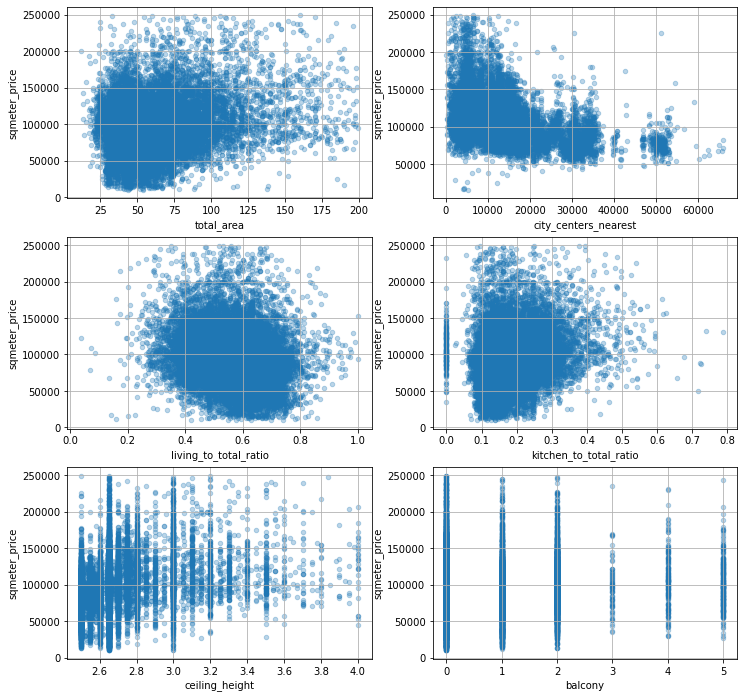

In [52]:
# Создание области figure и массива областей axes
fig, axes = plt.subplots(3, 2)
# Создание массива с параметрами
num_columns = ['total_area', 'city_centers_nearest', 'living_to_total_ratio', 'kitchen_to_total_ratio', 'ceiling_height', 'balcony']

# Отрисовка диаграмм рассеяния, отражающих связь параметров и цены за кв. метр
for i in range(len(num_columns)):
    (
        good_df.plot(kind='scatter', x=num_columns[i], y='sqmeter_price', grid=True, ax=axes[i//2, i%2], figsize=(12, 12), alpha=0.3)
    )

In [53]:
# Расчет коэффициентов корреляции Пирсона между стоимостью квартиры и параметрами из списка и вывод значений на экран
for column in num_columns:
    print(column, ': ', good_df[column].corr(good_df['sqmeter_price']))

total_area :  0.18044270704556828
city_centers_nearest :  -0.403522450357192
living_to_total_ratio :  -0.20691630639860897
kitchen_to_total_ratio :  0.21687716463939527
ceiling_height :  0.2825156747398602
balcony :  0.031657995908231415


По шкале Чеддока теснота линейной связи между ценой и рассмотренными параметрами не достигает заметной ни в одном из случаев. По диаграммам рассеяния также не видно отличительных особенностей. 

#### Зависимость от числа комнат

<AxesSubplot:xlabel='rooms'>

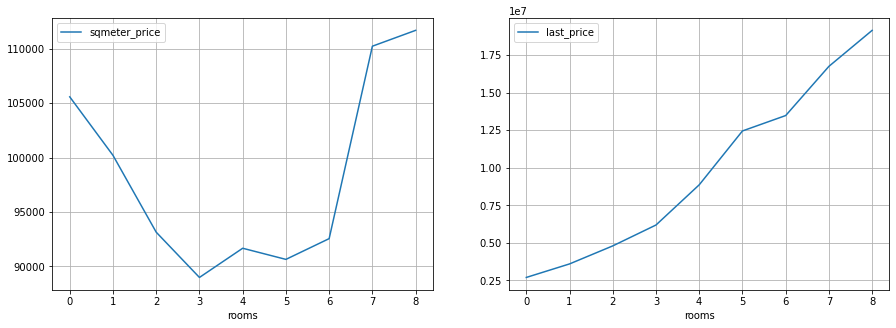

In [54]:
# Создание области figure и массива областей axes
fig, axes = plt.subplots(1, 2)

# Отрисовка графика зависимости медианной цены за кв. метр от количества комнат
(
    good_df.pivot_table(index='rooms', values='sqmeter_price', aggfunc='median')
       .plot(ax=axes[0], grid=True, figsize=(15, 5))
)

# Отрисовка графика зависимости медианы полной стоимости от количества комнат
(
    good_df.pivot_table(index='rooms', values='last_price', aggfunc='median')
       .plot(ax=axes[1], grid=True)
)

Интересное наблюдение: несмотря на то, что полная стоимость квартиры прямо пропорциональна числу комнат, цена квадратного метра достигает пиков в 0 и 8, и наоборот минимальна для квартир со средним числом комнат, а именно с 3. 

#### Разница в цене для апартаментов, студий и квартир с открытой планировкой

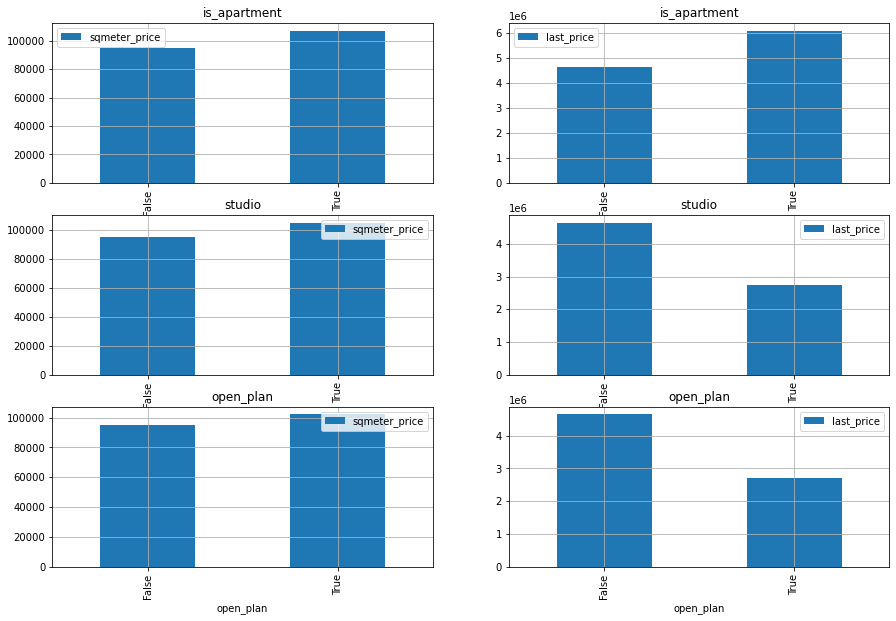

In [55]:
# Создание области figure и массива областей axes
fig, axes = plt.subplots(3, 2)
# Создание массива с параметрами
cat_columns = ['is_apartment', 'studio', 'open_plan']

# Отрисовка столбчатых диаграмм, отражающих медианы цены за кв. метр и полной стоимости квартир
for i in range(len(cat_columns)):
    (
        good_df.pivot_table(index=cat_columns[i], values='sqmeter_price', aggfunc='median')
               .plot(kind='bar', grid=True, ax=axes[i, 0], figsize=(15, 10), title=cat_columns[i])
    )
    (
        good_df.pivot_table(index=cat_columns[i], values='last_price', aggfunc='median')
               .plot(kind='bar', grid=True, ax=axes[i, 1], title=cat_columns[i])
    )

Подобно ситуации с числом комнат обстоит дело со студиями и квартирами со свободной планировкой (может, потому что в большинстве из них заявлено 0 комнат). Такие квартиры дешевле по общей стоимости, но дороже по цене за квадратный метр.

Что касается апартаментов, этот вид жилья дороже по обоим параметрам.

#### Зависимость от этажа

<AxesSubplot:xlabel='floor_category'>

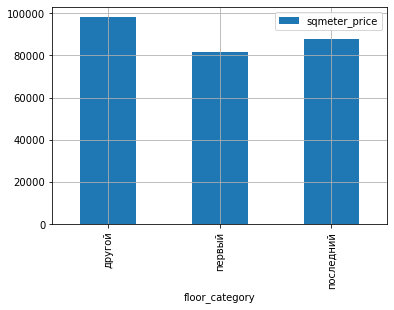

In [56]:
# Группировка датасета по категории этажа, вычисление медианных цен за кв. метр
# и отрисовка столбчатой диаграммы
good_df.pivot_table(index='floor_category', values='sqmeter_price', aggfunc='median') \
       .plot(kind='bar', grid=True)   

Квартиры, расположенные на первом и последнем этажах дешевле других. Причем на первом — самая низкая цена за кв. метр (возможно, потому что в них более шумно и нет вида из окна).

#### Зависимость от даты размещения объявления: дня недели, месяца и года.

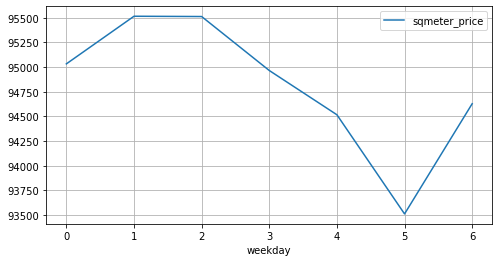

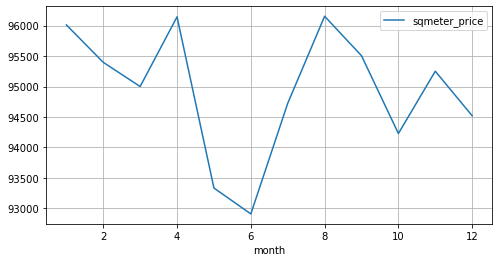

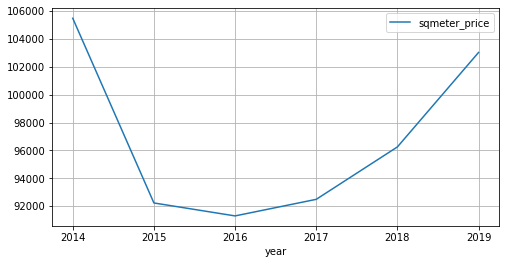

In [57]:
# Группировка датасета по дню недели, месяцу и году,
# отрисовка графиков зависимости медианной цены за кв. метр от этих параметров

for dt in ['weekday', 'month', 'year']:
    good_df.pivot_table(index=dt, values='sqmeter_price', aggfunc='median') \
           .plot(grid=True, figsize=(8, 4))

Цена за кв. метр была максимальной в 2014 году, затем пошла на спад, а после 2016 снова начала расти. Это может быть обосновано изменением экономической ситуации, в т.ч. покупательской способности. Отличия в цене за разные дни недели и месяцы скорее случайны, так как дата размещения объявления отличается от даты покупки.

### Данные по населенным пунктам

Выберем 10 населённых пунктов с наибольшим числом объявлений. Посчитаем среднюю цену квадратного метра в этих населённых пунктах.

In [58]:
# Создание сводной таблицы по населенным пунктам с данными о количестве объявлений и средней цене за кв. метр
locality_data = good_df.pivot_table(index='locality_name', values='sqmeter_price', aggfunc=['count', 'mean'])

# Переименование столбцов таблицы
locality_data.columns = ['count', 'mean']

# Сортировка таблицы по количеству объявлений на населенный пункт,
# выбор топ-10 из них
# и сортировка по цене за кв. метр
locality_data.sort_values(by='count', ascending=False) \
             .head(10) \
             .sort_values(by='mean', ascending=False)

,count,mean
locality_name,,
санкт-петербург,14325,110217.812263
пушкин,341,103005.958724
кудрово,427,95129.068696
парголово,285,90763.342784
мурино,549,85880.469491
шушары,398,78888.921616
колпино,304,75642.876899
гатчина,283,68479.908585
всеволожск,365,67102.774911


Среди населенных пунктов с наибольшим числом объявлений cамая высокая цена за кв. метр в городах Санкт-Петербург и Пушкин, низкая — во Всеволожске и Выборге.

### Определение центральной зоны

Создадим сегмент квартир в центре, чтобы сравнить показатели по нему с общими выводами по всей базе. Для этого:
1. Выделим квартиры в Санкт-Петербурге.
2. Создадим столбец с расстоянием до центра в километрах.
3. Посчитаем среднюю цену  для каждого километра.
4. Построим график и определим границу, где он сильно меняется.

<AxesSubplot:xlabel='city_centers_nearest_km'>

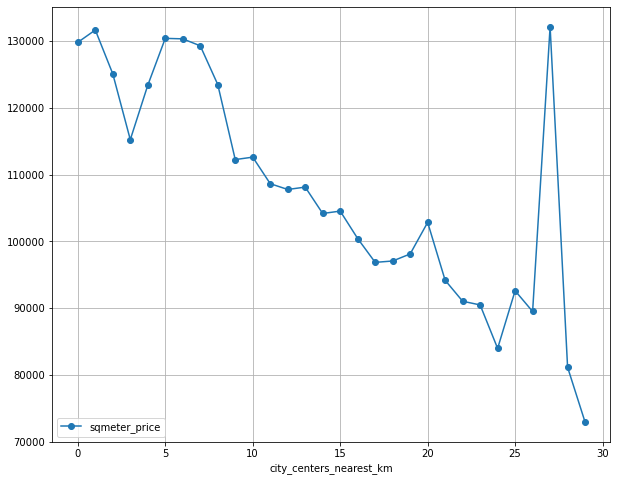

In [59]:
# Создадим переменную с данными по Санкт-Петербургу
center_data = good_df[good_df['locality_name'] == 'санкт-петербург']

# Удалим строки с пропусками в city_centers_nearest и создадим столбец с расстоянием в километрах
center_data = center_data.dropna(subset=['city_centers_nearest'])
center_data['city_centers_nearest_km'] = (center_data['city_centers_nearest'] / 1000).round().astype('int')

# Посчитаем среднюю цену для каждого километра и построим график
center_data.pivot_table(index='city_centers_nearest_km', values='sqmeter_price', aggfunc='mean') \
           .plot(style='o-', figsize=(10, 8), grid=True)

На графике присутствуют локальные максимумы в 27км и 5 км (они могут быть обоснованы, например, нахождением в историческом районе или хорошим видом). При этом резкий рост цен наблюдается начиная с 3км — этот радиус и примем за центральную зону.

In [60]:
# Отфильтруем объявления, находящиеся больше чем за 8км от центра
center_data = center_data[center_data['city_centers_nearest_km'] <= 3]

### Анализ сегмента квартир в центре

Изучим следующие параметры: площадь, цена, число комнат, высота потолков.

In [61]:
# Выведем основные статистики столбцов center_data
center_data[['total_area', 'sqmeter_price', 'rooms', 'ceiling_height']].describe()

,total_area,sqmeter_price,rooms,ceiling_height
count,740.000000,740.000000,740.000000,740.000000
mean,88.006108,122394.406452,2.979730,3.007541
std,35.967160,36897.565188,1.256483,0.364996
min,12.000000,28919.631094,0.000000,2.500000
25%,62.000000,95030.991736,2.000000,2.650000
50%,82.000000,114219.275381,3.000000,3.000000
75%,108.000000,139551.470588,4.000000,3.280000
max,198.000000,249056.603774,8.000000,4.000000


In [62]:
# Выведем основные статистики столбцов good_df
good_df[['total_area', 'sqmeter_price', 'rooms', 'ceiling_height']].describe()

,total_area,sqmeter_price,rooms,ceiling_height
count,21443.000000,21443.000000,21443.000000,21443.000000
mean,58.053359,96589.609968,2.038521,2.690184
std,26.142241,33505.621496,0.996454,0.196774
min,12.000000,10185.185185,0.000000,2.500000
25%,40.000000,76923.076923,1.000000,2.600000
50%,52.000000,95000.000000,2.000000,2.650000
75%,69.000000,113835.927260,3.000000,2.700000
max,199.200000,249375.000000,8.000000,4.000000


Для всех параметров значения по квартилям для квартир в центре выше. То есть, в среднем квартиры в центре больше по площади, количеству комнат, у них выше потолки и цена за кв. метр.

Повторим исследование факторов, влияющих на цену квартиры для центрального сегмента.

#### Зависимость от площади, удаленности от центра, доли жилой площади, доли площади кухни, высоты потолков, числа балконов

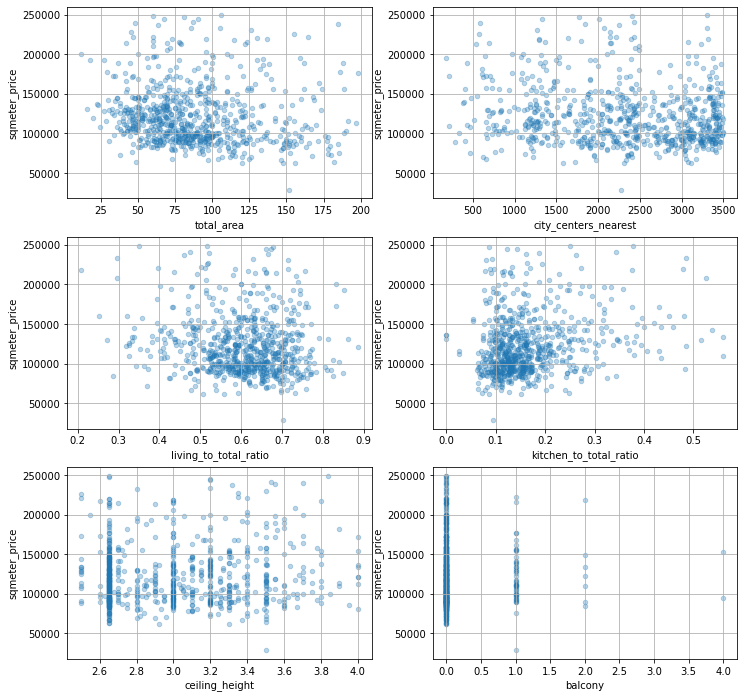

In [63]:
# Создание области figure и массива областей axes
fig, axes = plt.subplots(3, 2)
# Создание массива с параметрами
num_columns = ['total_area', 'city_centers_nearest', 'living_to_total_ratio', 'kitchen_to_total_ratio', 'ceiling_height', 'balcony']

# Отрисовка диаграмм рассеяния, отражающих связь параметров и цены за кв. метр
for i in range(len(num_columns)):
    (
        center_data.plot(kind='scatter', x=num_columns[i], y='sqmeter_price', grid=True, ax=axes[i//2, i%2], figsize=(12, 12), alpha=0.3)
    )

In [64]:
# Расчет коэффициентов корреляции Пирсона между стоимостью квартиры и параметрами из списка и вывод значений на экран
for column in num_columns:
    print(column, ': ', center_data[column].corr(center_data['sqmeter_price']))

total_area :  -0.11082806986480556
city_centers_nearest :  -0.15884854340889076
living_to_total_ratio :  -0.13011360407734665
kitchen_to_total_ratio :  0.22531738187443387
ceiling_height :  0.08219914157707278
balcony :  0.015198360179962218


Так же, как и по всей базе, по шкале Чеддока теснота линейной связи между ценой и рассмотренными параметрами не достигает заметной ни в одном из случаев. По диаграммам рассеивания особенностей также не наблюдается.

#### Зависимость от числа комнат

<AxesSubplot:xlabel='rooms'>

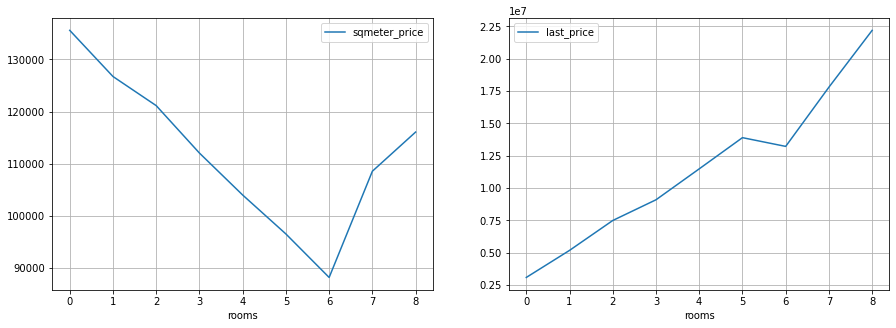

In [65]:
# Создание области figure и массива областей axes
fig, axes = plt.subplots(1, 2)

# Отрисовка графика зависимости медианной цены за кв. метр от количества комнат
(
    center_data.pivot_table(index='rooms', values='sqmeter_price', aggfunc='median')
               .plot(ax=axes[0], grid=True, figsize=(15, 5))
)

# Отрисовка графика зависимости медианы полной стоимости от количества комнат
(
    center_data.pivot_table(index='rooms', values='last_price', aggfunc='median')
               .plot(ax=axes[1], grid=True)
)

Если по всей базе минимальная цена достигалась для квартир с 3 комнатами, здесь — для 6 комнат.

#### Разница в цене для апартаментов, студий и квартир с открытой планировкой

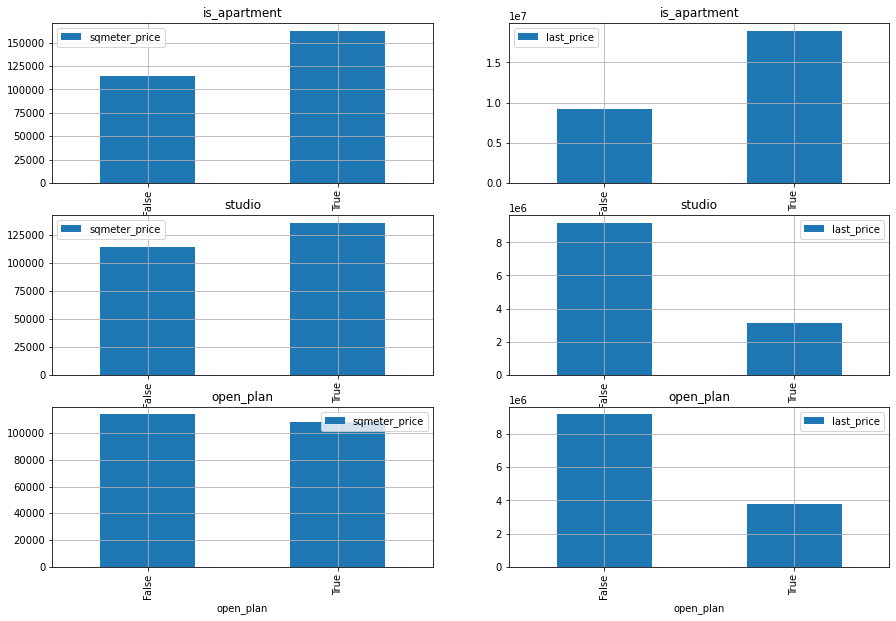

In [66]:
# Создание области figure и массива областей axes
fig, axes = plt.subplots(3, 2)
# Создание массива с параметрами
cat_columns = ['is_apartment', 'studio', 'open_plan']

# Отрисовка столбчатых диаграмм, отражающих медианы цены за кв. метр и полной стоимости квартир
for i in range(len(cat_columns)):
    (
        center_data.pivot_table(index=cat_columns[i], values='sqmeter_price', aggfunc='median')
                   .plot(kind='bar', grid=True, ax=axes[i, 0], figsize=(15, 10), title=cat_columns[i])
    )
    (
        center_data.pivot_table(index=cat_columns[i], values='last_price', aggfunc='median')
                   .plot(kind='bar', grid=True, ax=axes[i, 1], title=cat_columns[i])
    )

В отличие от общей базы, разница в полной стоимости более заметна для студий и квартир со свободной планировкой. Кроме того, цена за кв. метр для квартир со свободной планировкой ниже, когда по общей базе — выше.

#### Зависимость от этажа

<AxesSubplot:xlabel='floor_category'>

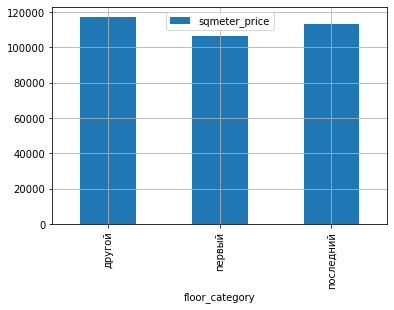

In [67]:
# Группировка датасета по категории этажа, вычисление медианных цен за кв. метр
# и отрисовка столбчатой диаграммы
(
    center_data.pivot_table(index='floor_category', values='sqmeter_price', aggfunc='median')
               .plot(kind='bar', grid=True)
)    

Аналогично общей базе, только разница менее выраженна.

#### Зависимость от даты размещения объявления: дня недели, месяца и года.

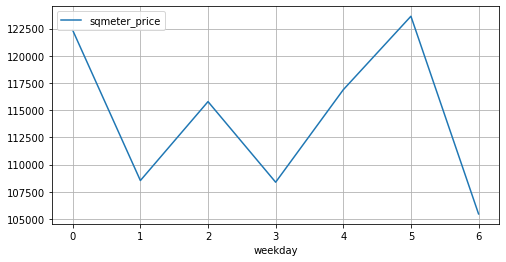

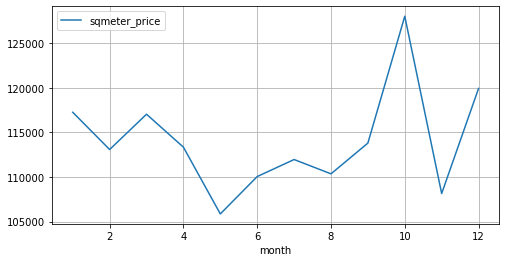

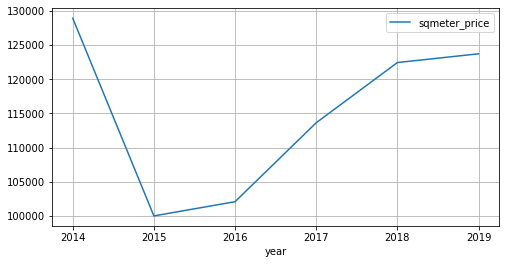

In [68]:
# Группировка датасета по дню недели, месяцу и году,
# отрисовка графиков зависимости медианной цены за кв. метр от этих параметров

for dt in ['weekday', 'month', 'year']:
    (
        center_data.pivot_table(index=dt, values='sqmeter_price', aggfunc='median')
                   .plot(grid=True, figsize=(8, 4))    
    )

Есть отличия от общей базы в данных по дням недели и месяцам, но мы решили принять это за случайность. Динамика по годам такая же: цена за кв. метр была максимальной в 2014 году, затем пошла на спад, после 2016 снова начала расти.

## Общий вывод

**Параметры, от которых зависит цена**
- Цена квадратного метра не зависит от общей площади, доли жилой площади, доли площади кухни, высоты потолков и числа балконов.
- Хотя квартиры до 3 комнат, студии и квартиры с открытой планировкой обычно ниже по общей стоимости, медианная цена за квадратный метр для них выше других квартир (приблизительно на 10 тыс.).
- Самая низкая цена за кв. метр для квартир с 3-6 комнатами.
- Цена на апартаменты (как за квадратный метр, так и общая) всегда выше цены обычных квартир.
- Квартиры, расположенные на первом и последнем этажах дешевле других (приблизительно на 10-15 тыс.).
- Цена отличается по годам размещения объявления, что может быть основано изменением экономической ситуации.

**Особенности центральной зоны**
- Цена квадратного метра выше (медиана равна 114000 против 95000 по всей базе).
- Квартиры больше по площади (медиана равна 82 кв.м. против 52 кв.м. по всей базе)
- Потолки выше (75% квартир имеют потолки выше 2.65 м., в то время как по всей базе лишь половина)
- Выгоднее покупать квартиры с открытой планировкой (они ниже не только по общей стоимости, но и по цене за кв. метр)
- Минимальная цена за кв. метр достигается для квартир с 6 комнатами

**Уточнения, пожелания**

Для получения дополнительных выводов необходимо восстановить пропуски:
- в столбце `days_exposition` за 2019 год (чтобы помимо цены изучить корреляцию между временем продажи и рассмотренными характеристиками).
- в столбцах, полученных из картографических данных (чтобы изучить, как влияет расстояние до ближайшего аэропорта/парка/пруда на цену и время продажи квартиры).